# final project

---
Please edit the cell below to include your name and student ID #

**name:**  Joseph Pariser

**SID:**  51698290

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from camutils import Camera,triangulate
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
import scipy

import cv2
import pandas as pd

%matplotlib inline

# ! pip install trimesh
import trimesh

# ! pip install open3d
import open3d as o3d

In [3]:
plt.rcParams['figure.figsize']=[15,15] #adjust this as needed to get clearly visible figures

***

# 1. Decoding

Write a function called **decode** that reads in a set of images captured with the camera showing the projected gray code and returns an array which is the same size as the camera image where each element contains the decoded value (0..1023) as well as a binary image (mask) indicating which pixels could be reliably decoded. We will end up calling this function 4 times, once for the horizontal and once for the vertical coordinates in both the left and right cameras. 


In [4]:
def generateImageList(imprefix, start, nbits):
    imageSet = list()
    for i in range(start, start + 2*nbits, 2):
        if i <= 9:
            N_1, N_2 = '0'+str(i), '0'+str(i+1)

        else:
            N_1, N_2 = str(i), str(i+1)

        image1 = imprefix + N_1 + ".png"
        image2 = imprefix + N_2 + ".png"

        imageSet.append( (image1, image2) ) 
    
    return imageSet


def convertToGrayscale(I):

    #convert to float data type if necessary
    if(I.dtype != float):    
        I = I.astype(float) / 255.0

    #convert from color to grayscale if necessary
    if(len(I.shape)==3 and I.shape[2] != 1):     
        I = I.mean(axis=2)

    return I
 

def exclusiveOR(A, B):
    M = A+B
    return np.where(M > 1, 0, M)


# convert from gray code to binary
def convertToBinaryImage(binaryImage, nbits):
     
    for i in range(1, nbits):
        A, B = binaryImage[..., i-1], binaryImage[..., i]
        binaryImage[..., i] = exclusiveOR( A, B )
    
    return binaryImage


 # convert from binary to decimal
def convertToDecimalImage(binaryImage, nbits):
      
    decimalImage = binaryImage[..., 0] * 2**( nbits-1)
    for i in range(1, nbits):
        decimalImage += binaryImage[..., i] * 2**(nbits-1-i)
        
    return decimalImage



In [5]:
def decode(imprefix,start,threshold):
    """
    Given a sequence of 20 images of a scene showing projected 10 bit gray code, 
    decode the binary sequence into a decimal value in (0,1023) for each pixel.
    Mark those pixels whose code is likely to be incorrect based on the user 
    provided threshold.  Images are assumed to be named "imageprefixN.png" where
    N is a 2 digit index (e.g., "img00.png,img01.png,img02.png...")
 
    Parameters
    ----------
    imprefix : str
       Image name prefix
      
    start : int
       Starting index
       
    threshold : float
       Threshold to determine if a bit is decodeable
       
    Returns
    -------
    code : 2D numpy.array (dtype=float)
        Array the same size as input images with entries in (0..1023)
        
    mask : 2D numpy.array (dtype=logical)
        Array indicating which pixels were correctly decoded based on the threshold
    
    """
    
    # we will assume a 10 bit code
    nbits = 10
    
    
    # genrate image list:    
    imageSet = generateImageList(imprefix, start, nbits)
    
    
    # loop through all pairs of images to get mask and nbit binary images
    for i, imagePair in enumerate(imageSet):
        
        # read images into array
        im1, im2 = plt.imread(imagePair[0]), plt.imread(imagePair[1])
        
        # don't forget to convert images to grayscale / float after loading them in
        image1, image2 = convertToGrayscale(im1), convertToGrayscale(im2)
        
        # take difference of images
        pos = np.where((image1 > image2), 1, 0)
        binaryDiff = np.where((image1 < image2), 0, pos)
        diff = np.abs(image1 - image2)
        

        # create mask and binaryImage(W, H, nbits)
        if i == 0:
            mask = np.where(diff<threshold, 0, 1)
            binaryImage = np.zeros((image1.shape[0], image1.shape[1], nbits))
            binaryImage[..., 0] = binaryDiff
            
        # update mask and add to binaryImage
        else:
            mask = np.where(diff<threshold, 0, mask)
            binaryImage[..., i] = binaryDiff


 
    # convert from gray code to binary 
    binaryImage = convertToBinaryImage(binaryImage, nbits)
        
    # convert from binary to decimal   
    code = convertToDecimalImage(binaryImage, nbits)
        
    return code,mask

In [6]:
def makerotation(rx,ry,rz):
    """
    Generate a rotation matrix    

    Parameters
    ----------
    rx,ry,rz : floats
        Amount to rotate around x, y and z axes in degrees

    Returns
    -------
    R : 2D numpy.array (dtype=float)
        Rotation matrix of shape (3,3)
    """
    
    rx = np.deg2rad(rx)
    ry = np.deg2rad(ry)
    rz = np.deg2rad(rz)
    
    cos = np.cos(rx)
    sin = np.sin(rx)
    Rx = np.array([[1,   0,    0],
                   [0, cos, -sin], 
                   [0, sin,  cos]])
    
    cos = np.cos(ry)
    sin = np.sin(ry)
    Ry = np.array([[cos, 0, sin], 
                   [0,   1,    0], 
                   [-sin, 0,  cos]])
    
    cos = np.cos(rz)
    sin = np.sin(rz)
    Rz = np.array([[cos, -sin, 0], 
                   [sin,  cos, 0], 
                   [0,   0,    1]])
    
    R = Rz@Ry@Rx
    
    return R
    
  

In [7]:
def calibratePose(pts3,pts2,cam,params_init):
    """
    Calibrate the provided camera by updating R,t so that pts3 projects
    as close as possible to pts2

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    cam : Camera
        Initial estimate of camera
        
    params_init : 1D numpy.array (dtype=float)
        Initial estimate of camera extrinsic parameters ()
        params[0:3] are the rotation angles, params[3:6] are the translation

    Returns
    -------
    cam : Camera
        Refined estimate of camera with updated R,t parameters
        
    """
    
    efun = lambda x : residuals(pts3, pts2, cam, x)
    
    params_opt, _ = scipy.optimize.leastsq(efun, params_init)
    
    cam.update_extrinsics(params_opt)
    
    return cam
 
    

In [8]:
def residuals(pts3,pts2,cam,params):
    """
    Compute the difference between the projection of 3D points by the camera
    with the given parameters and the observed 2D locations

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    params : 1D numpy.array (dtype=float)
        Camera parameters we are optimizing stored in a vector of shape (6,)

    Returns
    -------
    residual : 1D numpy.array (dtype=float)
        Vector of residual 2D projection errors of size 2*N
        
    """
    cam.update_extrinsics(params)
    temp = pts2 - cam.project(pts3)
    return temp.flatten()


In [9]:
def displayPlots(points3D):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(2,2,2)
    ax.plot(points3D[0,:],points3D[2,:],'.')
    plt.title('XZ-view')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('z')

    ax = fig.add_subplot(2,2,3)
    ax.plot(points3D[1,:],points3D[2,:],'.')
    plt.title('YZ-view')
    plt.grid()
    plt.xlabel('y')
    plt.ylabel('z')

    ax = fig.add_subplot(2,2,4)
    ax.plot(points3D[0,:],points3D[1,:],'.')
    plt.title('XY-view')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')

In [16]:
def reconstruct(imprefixL,imprefixR,threshold,camL,camR):
    """
    Performing matching and triangulation of points on the surface using structured
    illumination. This function decodes the binary graycode patterns, matches 
    pixels with corresponding codes, and triangulates the result.
    
    The returned arrays include 2D and 3D coordinates of only those pixels which
    were triangulated where pts3[:,i] is the 3D coordinte produced by triangulating
    pts2L[:,i] and pts2R[:,i]

    Parameters
    ----------
    imprefixL, imprefixR : str
        Image prefixes for the coded images from the left and right camera
        
    threshold : float
        Threshold to determine if a bit is decodeable
   
    camL,camR : Camera
        Calibration info for the left and right cameras
        
    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)
        The 2D pixel coordinates of the matched pixels in the left and right
        image stored in arrays of shape 2xN
        
    pts3 : 2D numpy.array (dtype=float)
        Triangulated 3D coordinates stored in an array of shape 3xN
        
    """

    # Decode the H and V coordinates for the two views
    H_l, Hmask_l = decode(imprefixL, 0, threshold)
    V_l, Vmask_l = decode(imprefixL, 20, threshold)
    
    H_r, Hmask_r = decode(imprefixR, 0, threshold)
    V_r, Vmask_r = decode(imprefixR, 20, threshold)
    

    # Construct the combined 20 bit code C = H + 1024*V and mask for each view
    C_l = (H_l + 1024*V_l) * (Hmask_l * Vmask_l)
    C_r = (H_r + 1024*V_r) * (Hmask_r * Vmask_r)
    
    
    # Find the indices of pixels in the left and right code image that 
    # have matching codes. If there are multiple matches, just
    # choose one arbitrarily.
    xy, matchL, matchR = np.intersect1d(C_l, C_r, return_indices=True)
    
    print('matches: ', matchL.shape)
    
    # Let CL and CR be the flattened arrays of codes for the left and right view
    # Suppose you have computed arrays of indices matchL and matchR so that 
    # CL[matchL[i]] == CR[matchR[i]] for all i.  The code below gives one approach
    # to generating the corresponding pixel coordinates for the matched pixels.
    
    h, w = C_l.shape
    
    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))
    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)


    # Now triangulate the points
    pts3 = triangulate(pts2L,camL,pts2R,camR)
    
    
    return pts2L,pts2R,pts3

***

## 1.2 Test and Visualize [5pts]

The graycode images which are projected are included in the data sub-directory **gray/**.  This is useful for
debugging your decode function prior to running it on the real scan data since the results should be perfect
(no noise!).  

1. Check that your decode function correct decodes the projector data
2. Visualize the results of running your decode function on one of the provided scans


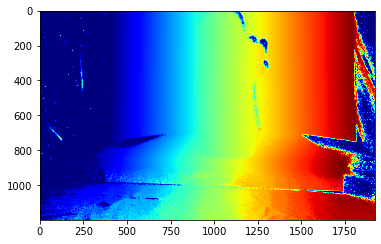

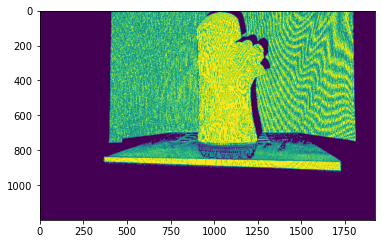

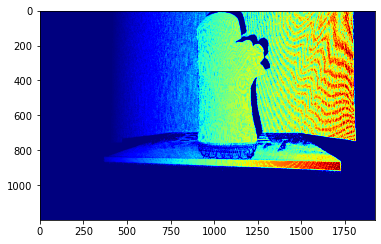

In [90]:
#
# first generate arrays containing the "true" codes projected by 
# the projector
#
# the projector had a resolution of 1280x800 so there are black bars 
# of 128 pixels on either side of our 1024 pixel region

pad = np.zeros((800,128))
hcode,vcode = np.meshgrid(range(1024),range(800))
Htrue = np.concatenate((pad,hcode,pad),axis=1)
Vtrue = np.concatenate((pad,vcode,pad),axis=1)
masktrue = np.concatenate((pad,np.ones((800,1024)),pad),axis=1)


#
# run your decoding on the projector images
#
thresh = 0.0000001  #this data is perfect so we can use a very small threshold
H,Hmask = decode('gray/',0,thresh)
V,Vmask = decode('gray/',20,thresh)


# compare to the known "true" code
assert((H==Htrue).all())
assert((V==Vtrue).all())
assert((Hmask==masktrue).all())
assert((Vmask==masktrue).all())


#
# Visualize results for the first scan and experiment to determine a good threshold
#
thresh = 0.00005
code,mask = decode('couple/grab_0_u/frame_C0_',0,thresh)

# diusplay view code and mask as images
plt.imshow(code, cmap='jet')
plt.show()
plt.imshow(mask)
plt.show()

plt.imshow(code*mask, cmap='jet')
plt.show()


***
# 2. Reconstruction 

We can now use the decoded pixel ids in order to easily find correspondences between two different camera views and triangulate the resulting points. You can use your own implementation from assignment 2 or import the provided **camutils.py** module as needed to do the triangulation. 

Camera : 
 f=1404.6009638781075 
 c=[[962.1672814 590.9159644]] 
 R=[[ 0.04237413  0.99207514  0.11828507]
 [ 0.87061206 -0.09474566  0.4827607 ]
 [ 0.49014188  0.08252384 -0.86772735]] 
 t = [[  8.15884783 -18.70825698  59.51710015]]
Camera : 
 f=1404.6009638781075 
 c=[[962.1672814 590.9159644]] 
 R=[[ 0.00217572  0.99082383  0.13514213]
 [ 0.65889094 -0.10307958  0.74514249]
 [ 0.75223533  0.0874227  -0.65306912]] 
 t = [[  7.63973009 -28.46393263  51.44184289]]


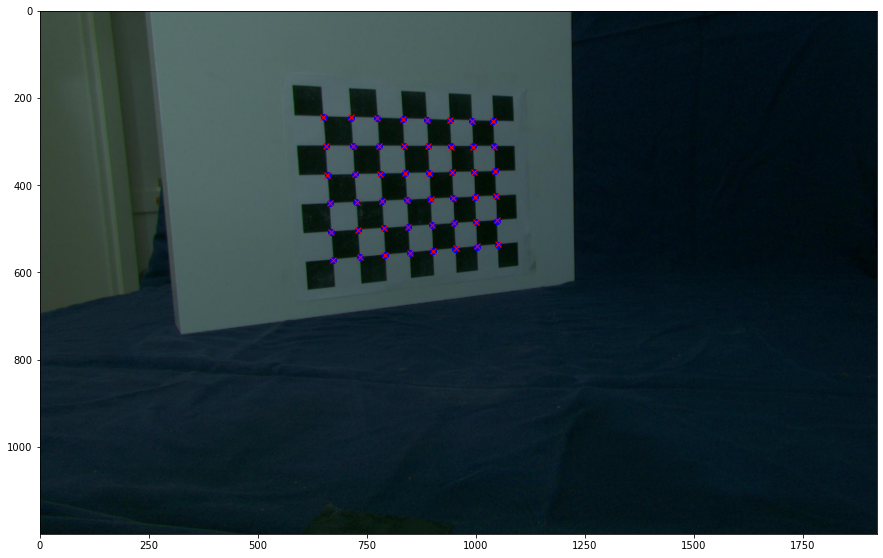

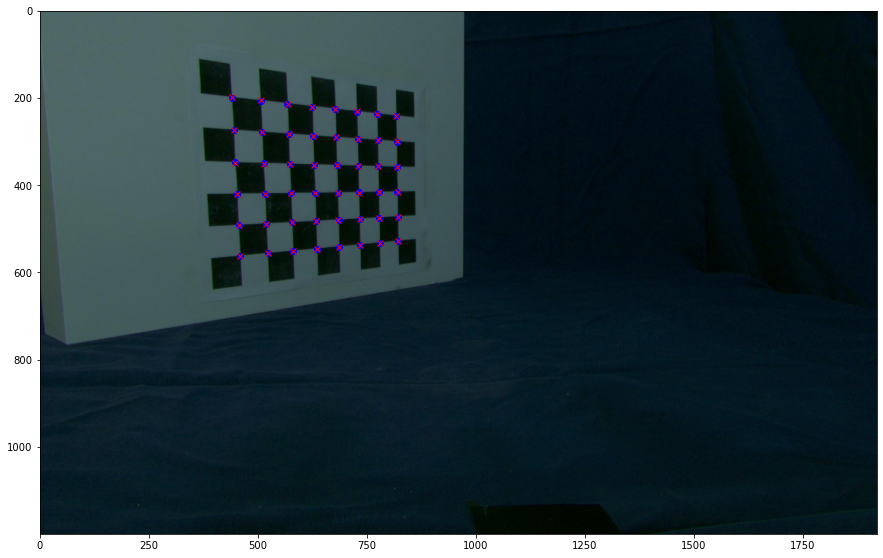

In [11]:
# load in the intrinsic camera parameters from 'calibration.pickle'
resultfile = 'CAM_calibration.pickle'
obj = pd.read_pickle('calibration.pickle')

fx, fy, cx, cy = obj.get('fx'), obj.get('fy'), obj.get('cx'), obj.get('cy')
f = (fx + fy) / 2.0

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
camL = Camera(f=f, c=np.array([[cx,cy]]).T, t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camR = Camera(f=f, c=np.array([[cx,cy]]).T, t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib_jpg_u/frame_C0_21.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib_jpg_u/frame_C1_21.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)


# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result

...
params_init = [0, 0, 0, 1, 1, -1]
camL = calibratePose(pts3,pts2L,camL,params_init)

params_init = [0, 0, 0, -1, 0, -1]
camR = calibratePose(pts3,pts2R,camR,params_init)

print(camL)
print(camR)

calib = {}
calib["camL"] = camL
calib["camR"] = camR


fid = open(resultfile, "wb" ) 
pickle.dump(calib,fid)
fid.close()

# As a final test, triangulate the corners of the checkerboard to get back their 3D locations
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()



***

## 2.2 Visualization [5pts]

I have provided the calibration for the two cameras in the scan0/scan0_calibration.pickle so that you can easily load them in to your code.  Call your **reconstruct** function on the provided image data and visualize the reconstructed 3D points to make sure everything is working. You may want to experiment with adjusting the decoding threshold to get a good number of points without too much noise. 

Please note that at this stage the results are quite noisy so if you plot them, you will probably need to zoom in to see the main object. You can adjust your plot axes to set the extent of the plot axis after displaying the points.  For this scan, axis limits of [-200 400],[-200 300], and [-200 200] in the x,y and z directions repectively should work well.


In [114]:
#
# Reconstruct and visualize the results
#
num = 5
imprefixC0 = f'couple/grab_{num}_u/frame_C0_'
imprefixC1 = f'couple/grab_{num}_u/frame_C1_'

# for 5:
cl = plt.imread(f'couple/grab_{num}_u/color_C0_00.png')

# cl = plt.imread(f'couple/grab_{num}_u/color_C0_01.png') - plt.imread(f'couple/grab_{num}_u/color_C0_00.png')
cl = np.where(cl<0, 0, cl)

print(cl.dtype)

threshold = 0.00005
obj = pd.read_pickle('CAM_calibration.pickle')
camL,camR = obj.get('camL'), obj.get('camR')
pts2L,pts2R,pts3 = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR)


float32
matches:  (239035,)


***

# 3. Meshing

To display the reconstructed scan as a surface, we need to generate triangular faces of the mesh which connect up the points. Write code that takes the output of **reconstruct** and produces a triangulated mesh. Your mesh should be represented by an array of points (vertices) and an array of triplets of point indices (triangular faces).



In [115]:
# Add your visualization code here.  As we have done previously it is good to visualize different
# 2D projections XY, XZ, YZ and well as a 3D version

# generate coordinates of a line segment running from the center
# of the camera to 3 units in front of the camera
# lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,20]]).T))
# lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,20]]).T))

# visualize the left and right image overlaid
# fig = plt.figure()
# ax = fig.add_subplot(2,2,1,projection='3d')
# ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
# ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
# ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
# ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
# ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
# visutils.set_axes_equal_3d(ax)
# visutils.label_axes(ax)
# plt.title('scene 3D view')

# ax = fig.add_subplot(2,2,2)
# ax.plot(pts3[0,:],pts3[2,:],'.')
# ax.plot(camR.t[0],camR.t[2],'ro')
# ax.plot(camL.t[0],camL.t[2],'bo')
# ax.plot(lookL[0,:],lookL[2,:],'b')
# ax.plot(lookR[0,:],lookR[2,:],'r')
# plt.title('XZ-view')
# plt.grid()
# plt.xlabel('x')
# plt.ylabel('z')

# ax = fig.add_subplot(2,2,3)
# ax.plot(pts3[1,:],pts3[2,:],'.')
# ax.plot(camR.t[1],camR.t[2],'ro')
# ax.plot(camL.t[1],camL.t[2],'bo')
# ax.plot(lookL[1,:],lookL[2,:],'b')
# ax.plot(lookR[1,:],lookR[2,:],'r')
# plt.title('YZ-view')
# plt.grid()
# plt.xlabel('y')
# plt.ylabel('z')

# ax = fig.add_subplot(2,2,4)
# ax.plot(pts3[0,:],pts3[1,:],'.')
# ax.plot(camR.t[0],camR.t[1],'ro')
# ax.plot(camL.t[0],camL.t[1],'bo')
# ax.plot(lookL[0,:],lookL[1,:],'b')
# ax.plot(lookR[0,:],lookR[1,:],'r')
# plt.title('XY-view')
# plt.grid()
# plt.xlabel('x')
# plt.ylabel('y')



pts3.shape    : (3, 239035)
x; points3D.shape: (3, 221839)
y; points3D.shape: (3, 136084)
z; points3D.shape: (3, 98142)
tri.shape: (196249, 3)
(98142, 3)


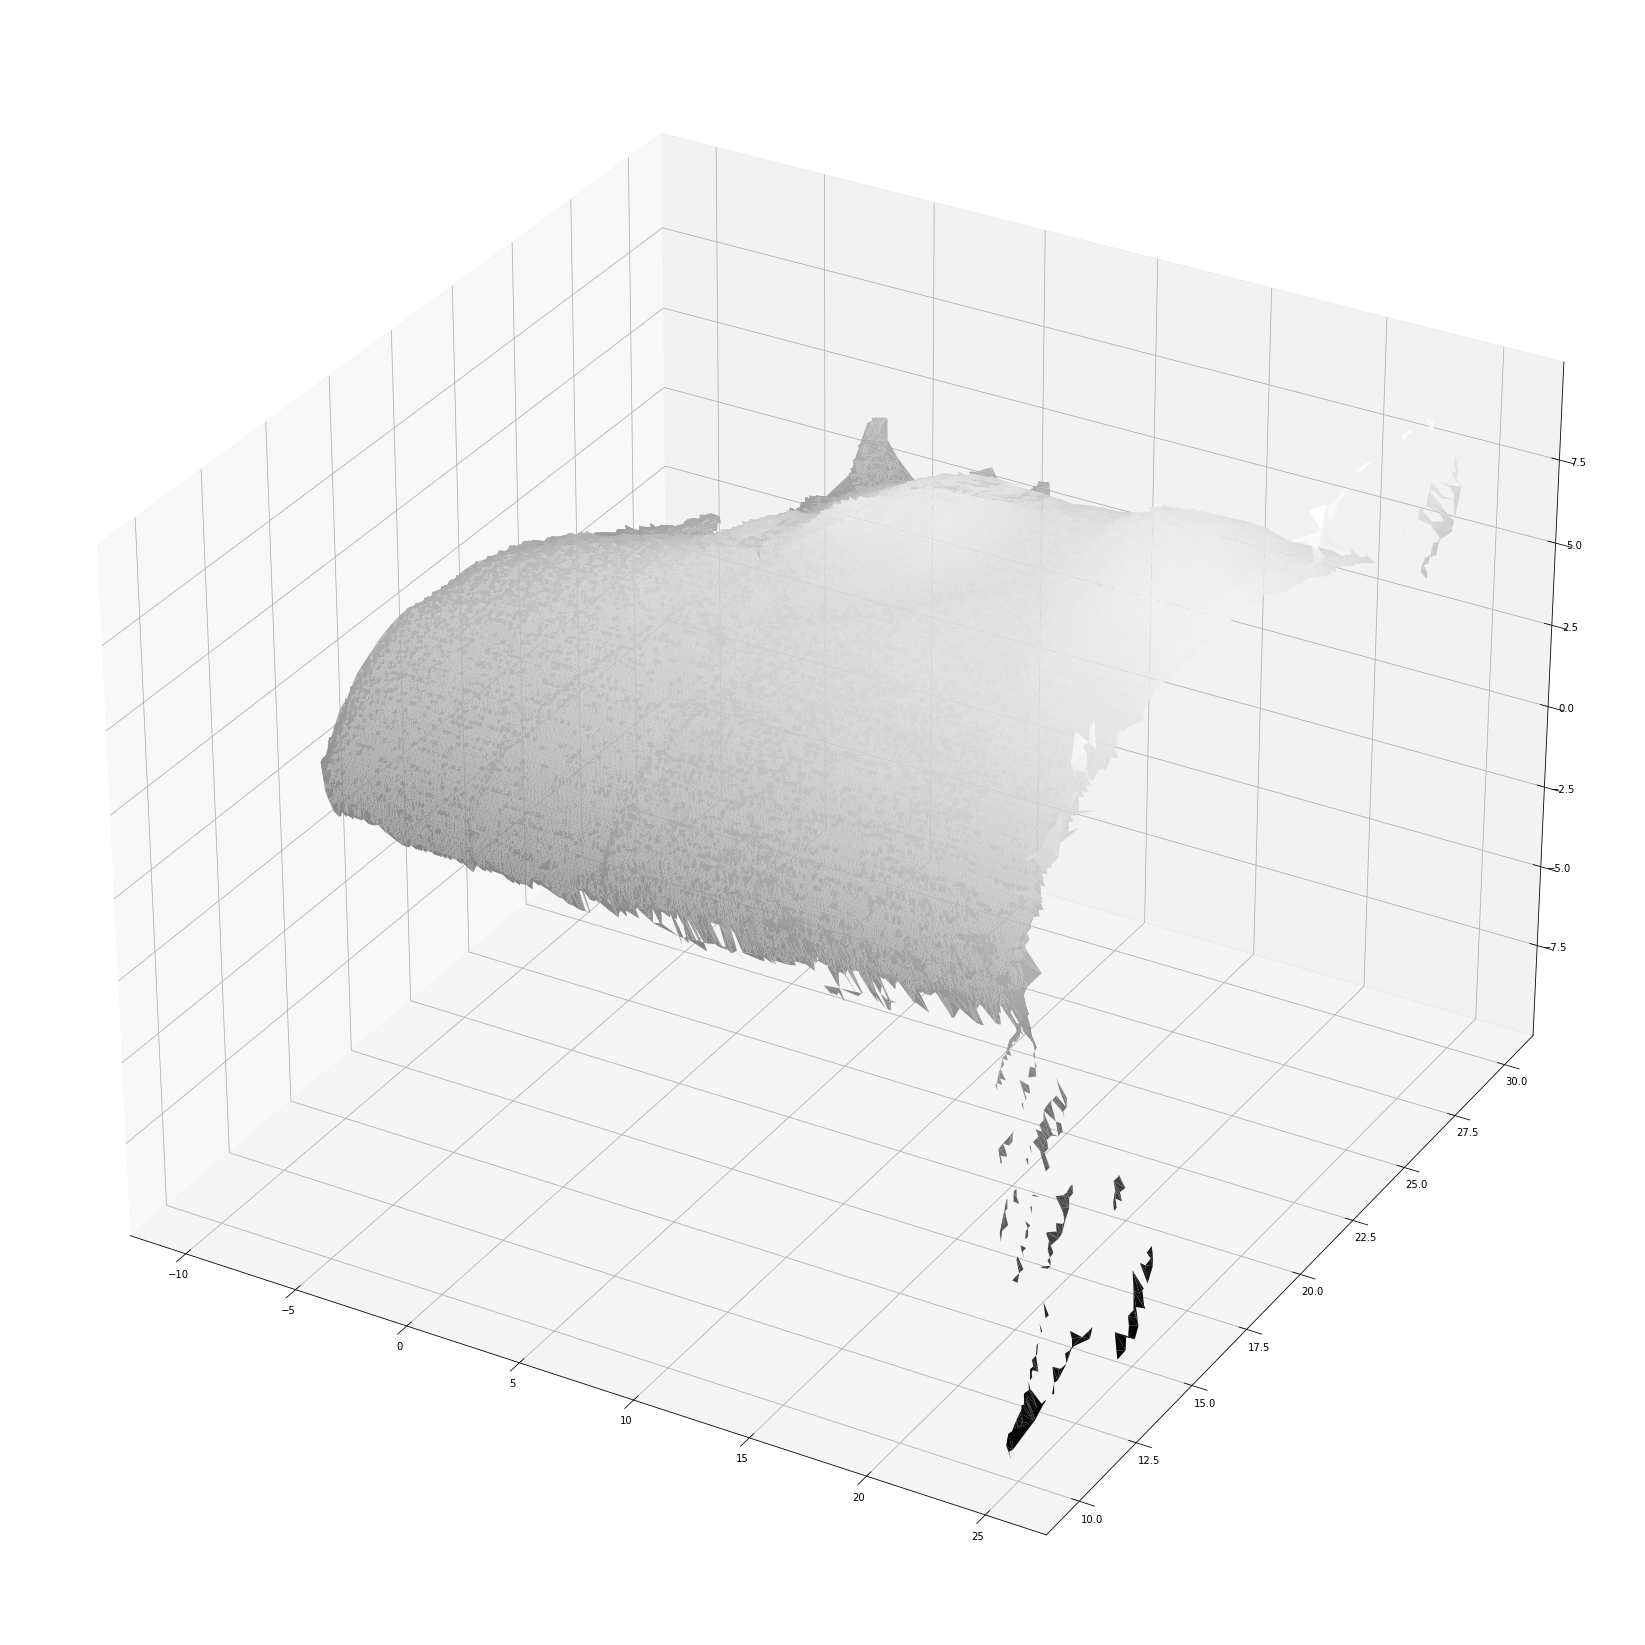

In [116]:
# Mesh cleanup parameters

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
boxlimits = np.array([-10, 25, 10, 30, -10, 10])

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
trithresh = 1

    
#
# bounding box pruning
#
print('pts3.shape    :', pts3.shape)
points3D = pts3[:, np.where( (pts3[0]>boxlimits[0]) & (pts3[0]<boxlimits[1]) )[0]]
print('x; points3D.shape:', points3D.shape)
points3D = points3D[:, np.where( (points3D[1]>boxlimits[2]) & (points3D[1]<boxlimits[3]) )[0]]
print('y; points3D.shape:', points3D.shape)
points3D = points3D[:, np.where( (points3D[2]>boxlimits[4]) & (points3D[2]<boxlimits[5]) )[0]]

print('z; points3D.shape:', points3D.shape)


# tri adjustments.....
#
# triangulate the 2D points to get the surface mesh
#
points = camL.project(points3D)
tri = Delaunay(points.T).simplices

#
# triangle pruning
#
small_edges = list()
for tr in tri[:]:
    x, y, z = tr
    XY = np.linalg.norm( points3D[:, x] - points3D[:, y])
    XZ = np.linalg.norm( points3D[:, x] - points3D[:, z])
    YZ = np.linalg.norm( points3D[:, y] - points3D[:, z])
    
    if max(XY, XZ, YZ) < trithresh:
        small_edges.append(1)
    else:
        small_edges.append(0)


#
# remove any points which are not refenced in any triangle
#
print('tri.shape:', tri.shape)
ind = np.array(small_edges)
tri = tri[ind==1]

# display triangle mesh

fig2 = plt.figure(figsize=(30,30))
ax = fig2.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(points3D[0,:], points3D[1,:], points3D[2,:], triangles=tri, cmap='gray')
# displayPlots(points3D)


points = points.astype(int)
colorsL = cl[points[1], points[0]]
print(colorsL.shape)

plt.show()


In [117]:

# vis code goes here


#
# example code using plot_trisurf to visualize... this will be 
# a bit slow so you have to be patiennt
#
# fig1 = plt.figure(figsize=(30,30))
# ax = fig1.add_subplot(111, projection='3d')
# ax.plot_trisurf(points3D[0,:], points3D[1,:], points3D[2,:], triangles=tri, antialiased=False)
# ax.view_init(azim=0,elev=40)  #set the camera viewpointn
# visutils.set_axes_equal_3d(ax)
# visutils.label_axes(ax)
# plt.title('Final Mesh View 1')
# plt.show()

#
# An alternative is to use the trimesh library (https://github.com/mikedh/trimesh)
# you will need to install it via. "pip install trimesh"
# A nice feature is that it will create a plot which is interactive (so you can
# drag with the mouse pointer to rotate the 3D mesh to view from different directions)
#



# colors = plt.imread()




<class 'trimesh.base.Trimesh'>


In [ ]:
mesh = trimesh.Trimesh(vertices=points3D.T,faces=tri[:,[0,2,1]], vertex_colors=colorsL)
pc = trimesh.points.PointCloud(vertices=points3D.T, colors=colorsL)
print(type(mesh))
# trimesh.visual.color.ColorVisuals(mesh, vertex_colors=colors)
mesh.show()

In [118]:

# trimesh.exchange.ply.export_ply(mesh, encoding='binary')
mesh.export(f'color_mesh{num}.ply')
print("mesh is exporting")

mesh is exporting


In [90]:
# cl = plt.imread(f'couple/grab_{num}_u/color_C0_01.png') - plt.imread(f'couple/grab_{num}_u/color_C0_00.png')
# cr = plt.imread(f'couple/grab_{num}_u/color_C1_01.png') - plt.imread(f'couple/grab_{num}_u/color_C1_00.png')
# plt.imshow(cr)
# plt.show()

In [91]:
# for i, facet in enumerate(mesh.facets):
#     mesh.visual.face_colors[facet] = colorsL[i]

# mesh.show()

In [92]:
# m = trimesh.visual.ColorVisuals(mesh=mesh, face_colors=None, vertex_colors=colorsL)

# for i, facet in enumerate(mesh.facets):
#     mesh.visual.face_colors[facet] = trimesh.visual.color.to_rgba(colorsL[i])
# mesh.show()


# f_color = trimesh.visual.color.vertex_to_face_color(vertex_colors=colorsL, faces=tri[:,[0,2,1]])

# mesh = trimesh.Trimesh(vertices=points3D.T,faces=tri[:,[0,2,1]], face_color=f_color)

# mesh.show()